# EC performance analysis

In [23]:
%load_ext autoreload
%autoreload 2

from gnn_tracking.training.ec import ECModule
from lstcondensation.util import find_latest_checkpoint
from pathlib import Path
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(("science", "notebook"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
log_dir = Path(
    "/home/kl5675/Documents/23/git_sync/lst-condensation-hackathon/scripts/lightning_logs/"
)

ckpt_path = find_latest_checkpoint(log_dir / "prompt-nonchalant-swift")
ec = ECModule.load_from_checkpoint(ckpt_path, map_location="cpu")

[11:21:24] DEBUG: Getting class EFMLP from module gnn_tracking.models.edge_filter
[11:21:24] DEBUG: Getting class HaughtyFocalLoss from module gnn_tracking.metrics.losses


/home/kl5675/Documents/23/git_sync/lst-condensation-hackathon/scripts/lightning_logs/prompt-nonchalant-swift/checkpoints
/home/kl5675/Documents/23/git_sync/lst-condensation-hackathon/scripts/lightning_logs/prompt-nonchalant-swift/checkpoints/epoch=195-step=117600.ckpt


In [25]:
ec

ECModule(
  (model): EFMLP(
    (encoder): Linear(in_features=21, out_features=128, bias=False)
    (decoder): Linear(in_features=128, out_features=1, bias=False)
    (layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=False)
    )
  )
  (loss_fct): HaughtyFocalLoss()
)

In [26]:
from gnn_tracking.analysis.edge_classification import collect_all_ec_stats

In [27]:
from lstcondensation.loader import default_data_module

default_data_module.setup(stage="test")

[11:21:25] INFO: DataLoader will load 5 graphs (out of 175 available).
[11:21:25] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v1/processed/0170.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v1/processed/0174.pt


In [28]:
import numpy as np

df = collect_all_ec_stats(
    ec,
    default_data_module.test_dataloader(),
    thresholds=np.linspace(0.0, 0.1, 8),
    max_workers=3,
)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
df.columns

Index(['threshold', 'acc', 'TPR', 'TNR', 'FPR', 'FNR', 'balanced_acc', 'F1',
       'MCC', 'n_true', 'n_false', 'n_predicted_true', 'n_predicted_false',
       'acc_thld', 'TPR_thld', 'TNR_thld', 'FPR_thld', 'FNR_thld',
       'balanced_acc_thld', 'F1_thld', 'MCC_thld', 'n_true_thld',
       'n_false_thld', 'n_predicted_true_thld', 'n_predicted_false_thld',
       'n_orphan_correct', 'n_orphan_incorrect', 'n_orphan_total',
       'frac_segment100', 'frac_component100', 'frac_segment50',
       'frac_component50', 'frac_segment75', 'frac_component75', 'n_segments',
       'frac_hits_largest_segment', 'frac_hits_largest_component',
       'threshold_err', 'acc_err', 'TPR_err', 'TNR_err', 'FPR_err', 'FNR_err',
       'balanced_acc_err', 'F1_err', 'MCC_err', 'n_true_err', 'n_false_err',
       'n_predicted_true_err', 'n_predicted_false_err', 'acc_thld_err',
       'TPR_thld_err', 'TNR_thld_err', 'FPR_thld_err', 'FNR_thld_err',
       'balanced_acc_thld_err', 'F1_thld_err', 'MCC_thld_err',


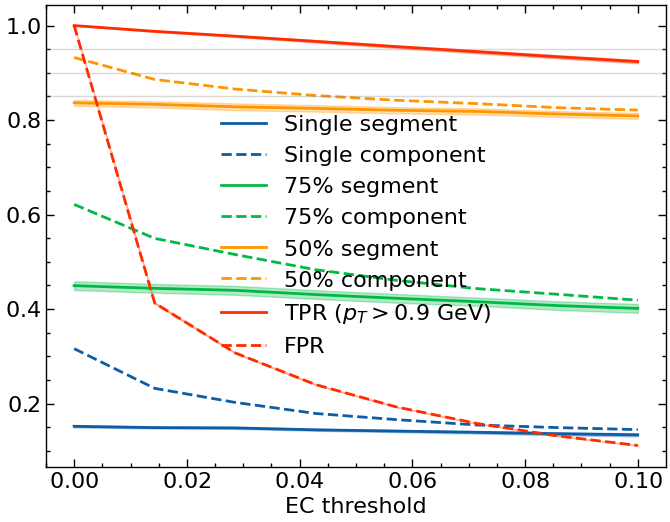

In [30]:
from gnn_tracking.analysis.edge_classification import ThresholdTrackInfoPlot

ttip = ThresholdTrackInfoPlot(df)
ttip.setup_axes()
ttip.plot_100()
ttip.plot_75()
ttip.plot_50()
ttip.plot_tpr_fpr()
ttip.plot_hlines()
# ttip.plot_mcc()
ttip.add_legend()

In [31]:
out = ec(default_data_module.datasets["test"][0])

(array([25699.,  2784.,  1986.,  1609.,  1336.,  1223.,  1124.,   978.,
         1005.,   973.,   884.,   832.,   875.,   827.,   813.,   887.,
          784.,   814.,   840.,   786.,   774.,   840.,   795.,   815.,
          864.,   827.,   832.,   855.,   880.,   904.,   913.,   935.,
          930.,   955.,   948.,  1005.,  1041.,  1029.,  1149.,  1054.,
         1129.,  1139.,  1203.,  1136.,  1135.,  1100.,  1204.,  1187.,
         1212.,  1200.,  1204.,  1287.,  1329.,  1314.,  1251.,  1268.,
         1251.,  1205.,  1265.,  1236.,  1250.,  1141.,  1169.,  1130.,
         1113.,  1108.,  1045.,   938.,   946.,   829.,   831.,   759.,
          724.,   684.,   604.,   632.,   565.,   515.,   513.,   446.,
          440.,   413.,   429.,   440.,   447.,   433.,   491.,   490.,
          570.,   585.,   595.,   658.,   755.,   843.,   958.,  1133.,
         1310.,  1206.,   842.,   129.]),
 array([-3.        , -2.97024465, -2.94048905, -2.9107337 , -2.88097835,
        -2.85122275, 

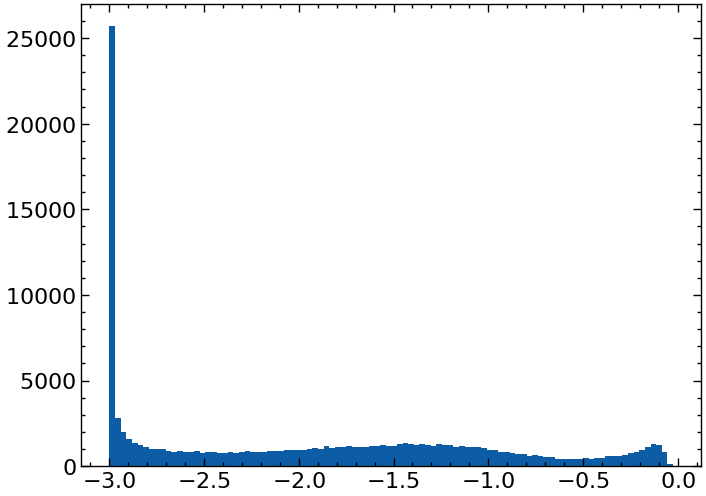

In [32]:
import torch
from matplotlib import pyplot as plt

plt.hist(torch.log10(out["W"].detach()), bins=100)

In [33]:
# Best

In [34]:
from gnn_tracking.utils.dictionaries import add_key_suffix
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats
from gnn_tracking.utils.graph_masks import (
    get_edge_mask_from_node_mask,
    get_good_node_mask,
)
from tqdm import tqdm
from gnn_tracking.metrics.cluster_metrics import flatten_track_metrics
import pandas as pd
from gnn_tracking.analysis.graphs import get_cc_labels
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_data,
    tracking_metric_df,
)


def _get_maximum_dm_stats(data, module, cutoffs):
    results = []
    weights = module(data)["W"]
    for cutoff in cutoffs:
        dc = data.edge_subgraph(weights > cutoff)
        assert dc.num_nodes == data.num_nodes
        y = dc.y.bool()
        ei = dc.edge_index[:, y]
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        r = flatten_track_metrics(
            tracking_metrics_data(dc, labels.detach().cpu().numpy(), [0.9])
        )
        r["threshold"] = cutoff
        edge_mask = get_edge_mask_from_node_mask(
            get_good_node_mask(data, pt_thld=0.9, max_eta=4), data.edge_index
        )
        bcs_thld = BinaryClassificationStats(
            output=weights[edge_mask], y=data.y[edge_mask].long(), thld=cutoff
        )
        bcs = BinaryClassificationStats(output=weights, y=data.y.long(), thld=cutoff)
        r |= add_key_suffix(bcs_thld.get_all(), "_thld")
        r |= bcs.get_all()
        results.append(r)
    return pd.DataFrame.from_records(results)


def get_maximum_dm_stats(module, dataloader, cutoffs):
    results = []
    for data in tqdm(dataloader):
        results.append(_get_maximum_dm_stats(data, module, cutoffs))
    dfs_concat = pd.concat(results)
    cols = dfs_concat.columns
    df = dfs_concat.groupby("threshold").agg(["mean", "std", "size"]).reset_index()
    for c in cols:
        if c == "threshold":
            continue
        mean = df[(c, "mean")]
        df[f"{c}_err"] = df[(c, "std")] / (df[(c, "size")] ** 0.5)
        df.drop(columns=[(c, "mean"), (c, "std"), (c, "size")], inplace=True)
        df[c] = mean
    df.columns = df.columns.get_level_values(0)
    return df


def _get_cc_dm_stats(data, module, cutoffs):
    results = []
    weights = module(data)["W"]
    for cutoff in cutoffs:
        dc = data.edge_subgraph(weights > cutoff)
        ei = dc.edge_index
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        r = flatten_track_metrics(
            tracking_metrics_data(dc, labels.detach().cpu().numpy(), [0.9])
        )
        r["threshold"] = cutoff
        results.append(r)
    return pd.DataFrame.from_records(results)


def get_cc_dm_stats(module, dataloader, cutoffs):
    results = []
    for data in tqdm(dataloader):
        results.append(_get_cc_dm_stats(data, module, cutoffs))
    dfs_concat = pd.concat(results)
    cols = dfs_concat.columns
    df = dfs_concat.groupby("threshold").agg(["mean", "std", "size"]).reset_index()
    for c in cols:
        if c == "threshold":
            continue
        mean = df[(c, "mean")]
        df[f"{c}_err"] = df[(c, "std")] / (df[(c, "size")] ** 0.5)
        df.drop(columns=[(c, "mean"), (c, "std"), (c, "size")], inplace=True)
        df[c] = mean
    df.columns = df.columns.get_level_values(0)
    return df


def get_cc_details(module, dataloader, cutoff):
    h_dfs = []
    c_dfs = []
    for data in tqdm(dataloader):
        weights = module(data)["W"]
        dc = data.edge_subgraph(weights > cutoff)
        ei = dc.edge_index
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        h_df = pd.DataFrame(
            {
                "c": labels,
                "id": data.particle_id,
                "reconstructable": data.reconstructable,
                "pt": data.pt,
                "eta": data.eta,
            }
        )
        c_df = tracking_metric_df(h_df)
        h_dfs.append(h_df)
        c_dfs.append(c_df)
    return h_dfs, c_dfs

In [35]:
data = default_data_module.datasets["test"][0]

In [36]:
_get_maximum_dm_stats(data, ec, [0.0])

,n_particles_pt0.9,n_cleaned_clusters_pt0.9,perfect_pt0.9,double_majority_pt0.9,lhc_pt0.9,fake_perfect_pt0.9,fake_double_majority_pt0.9,fake_lhc_pt0.9,threshold,acc_thld,...,TNR,FPR,FNR,balanced_acc,F1,MCC,n_true,n_false,n_predicted_true,n_predicted_false
0,1244,1065,0.557074,0.835209,1.0,0.349296,0.024413,0.0,0.0,0.603424,...,0.0,1.0,0.0,0.5,0.164306,0,10720,109048,119768,0


In [37]:
y = data.y.bool()
ei = data.edge_index[:, y]
labels = get_cc_labels(ei, num_nodes=data.num_nodes)
flatten_track_metrics(tracking_metrics_data(data, labels.detach().cpu().numpy(), [0.9]))

{'n_particles_pt0.9': 1244,
 'n_cleaned_clusters_pt0.9': 1065,
 'perfect_pt0.9': 0.5570739549839229,
 'double_majority_pt0.9': 0.8352090032154341,
 'lhc_pt0.9': 1.0,
 'fake_perfect_pt0.9': 0.3492957746478873,
 'fake_double_majority_pt0.9': 0.024413145539906103,
 'fake_lhc_pt0.9': 0.0}

In [38]:
data.particle_id[ei[0]] == data.particle_id[ei[1]]

tensor([True, True, True,  ..., True, True, True])

In [39]:
thlds = [0] + np.logspace(-5, -1, 10).tolist() + np.linspace(0.1, 1, 20).tolist()
dfcc = get_cc_dm_stats(ec, default_data_module.test_dataloader(), thlds)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.40s/it]


In [47]:
dfcc.columns

Index(['threshold', 'n_particles_pt0.9_err', 'n_particles_pt0.9',
       'n_cleaned_clusters_pt0.9_err', 'n_cleaned_clusters_pt0.9',
       'perfect_pt0.9_err', 'perfect_pt0.9', 'double_majority_pt0.9_err',
       'double_majority_pt0.9', 'lhc_pt0.9_err', 'lhc_pt0.9',
       'fake_perfect_pt0.9_err', 'fake_perfect_pt0.9',
       'fake_double_majority_pt0.9_err', 'fake_double_majority_pt0.9',
       'fake_lhc_pt0.9_err', 'fake_lhc_pt0.9'],
      dtype='object')

In [40]:
dfmdm = get_maximum_dm_stats(ec, default_data_module.test_dataloader(), thlds)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


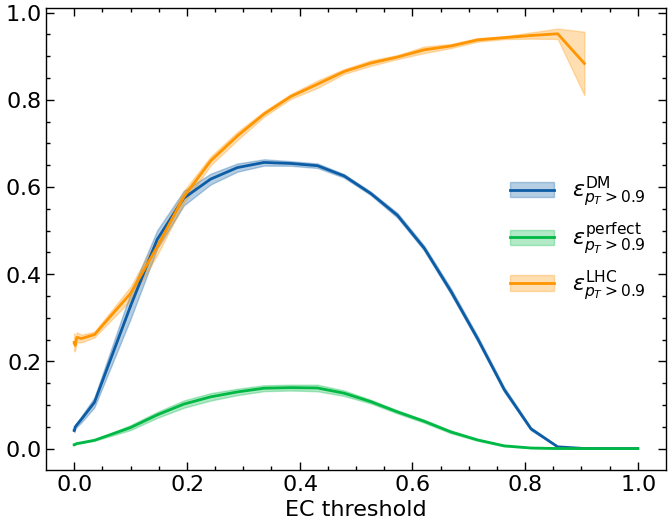

In [41]:
class CCPlot:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self._legend_items = []
        self.fig, ax = plt.subplots()
        ax.set_xlabel("EC threshold")
        self.ax = ax

    def plot_errorline(self, key, label="", ax=None, **kwargs):
        if ax is None:
            ax = self.ax
        line, *_ = ax.plot(
            self.df.threshold,
            self.df[key],
            **kwargs,
        )
        color = line.get_color()
        shading = ax.fill_between(
            self.df.threshold,
            self.df[key] - self.df[f"{key}_err"],
            self.df[key] + self.df[f"{key}_err"],
            color=color,
            alpha=0.3,
        )
        self._legend_items.append(((line, shading), label))
        return color

    def plot_dm(self):
        self.plot_errorline(
            "double_majority_pt0.9",
            label=r"$\epsilon^{\mathrm{DM}}_{p_T > 0.9}$",
        )

    def plot_perfect(self):
        self.plot_errorline(
            "perfect_pt0.9",
            label="$\epsilon^{\mathrm{perfect}}_{p_T > 0.9}$",
        )

    def plot_lhc(self):
        self.plot_errorline(
            "lhc_pt0.9",
            label="$\epsilon^{\mathrm{LHC}}_{p_T > 0.9}$",
        )

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)


ccp = CCPlot(dfcc)
ccp.plot_dm()
ccp.plot_perfect()
ccp.plot_lhc()
ccp.add_legend()
# ccp.ax.axvline(dfcc_dm_max_thld, color="black", ls=":")
ccp.ax.get_figure().savefig("ccp.pdf")

In [42]:
class ThresholdPossibilityInfoPlot:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self._legend_items = []
        self.fig, ax = plt.subplots()
        ax.set_xlabel("EC threshold")
        self.ax = ax
        self.log_ax = ax.twinx()
        self.log_ax.set_yscale("log")
        self.log_ax.set_ylabel("FPR", color="C3")
        self.log_ax.tick_params(axis="y", labelcolor="C3")

    def plot(self):
        self.plot_dm()
        self.plot_perfect()
        self.plot_tpr_fpr()

    def plot_errorline(self, key, label="", ax=None, **kwargs):
        if ax is None:
            ax = self.ax
        line, *_ = ax.plot(
            self.df.threshold,
            self.df[key],
            **kwargs,
        )
        color = line.get_color()
        shading = ax.fill_between(
            self.df.threshold,
            self.df[key] - self.df[f"{key}_err"],
            self.df[key] + self.df[f"{key}_err"],
            color=color,
            alpha=0.3,
        )
        self._legend_items.append(((line, shading), label))
        return color

    def plot_dm(self):
        self.plot_errorline(
            "double_majority_pt0.9",
            label=r"Upper bound on $\epsilon^{\mathrm{DM}}_{p_T > 0.9}$",
        )

    def plot_perfect(self):
        self.plot_errorline(
            "perfect_pt0.9",
            label="Upper bound on $\epsilon^{\mathrm{perfect}}_{p_T > 0.9}$",
        )

    def plot_tpr_fpr(self):
        self.plot_errorline(
            "TPR_thld",
            label=r"TPR (tracks of interest)",
            ls="--",
        )
        self.plot_errorline(
            "FPR", label="FPR (log scale)", ls="--", ax=self.log_ax, color="C3"
        )

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)

In [49]:
dfmdm.columns

Index(['threshold', 'n_particles_pt0.9_err', 'n_particles_pt0.9',
       'n_cleaned_clusters_pt0.9_err', 'n_cleaned_clusters_pt0.9',
       'perfect_pt0.9_err', 'perfect_pt0.9', 'double_majority_pt0.9_err',
       'double_majority_pt0.9', 'lhc_pt0.9_err', 'lhc_pt0.9',
       'fake_perfect_pt0.9_err', 'fake_perfect_pt0.9',
       'fake_double_majority_pt0.9_err', 'fake_double_majority_pt0.9',
       'fake_lhc_pt0.9_err', 'fake_lhc_pt0.9', 'acc_thld_err', 'acc_thld',
       'TPR_thld_err', 'TPR_thld', 'TNR_thld_err', 'TNR_thld', 'FPR_thld_err',
       'FPR_thld', 'FNR_thld_err', 'FNR_thld', 'balanced_acc_thld_err',
       'balanced_acc_thld', 'F1_thld_err', 'F1_thld', 'MCC_thld_err',
       'MCC_thld', 'n_true_thld_err', 'n_true_thld', 'n_false_thld_err',
       'n_false_thld', 'n_predicted_true_thld_err', 'n_predicted_true_thld',
       'n_predicted_false_thld_err', 'n_predicted_false_thld', 'acc_err',
       'acc', 'TPR_err', 'TPR', 'TNR_err', 'TNR', 'FPR_err', 'FPR', 'FNR_err',
      

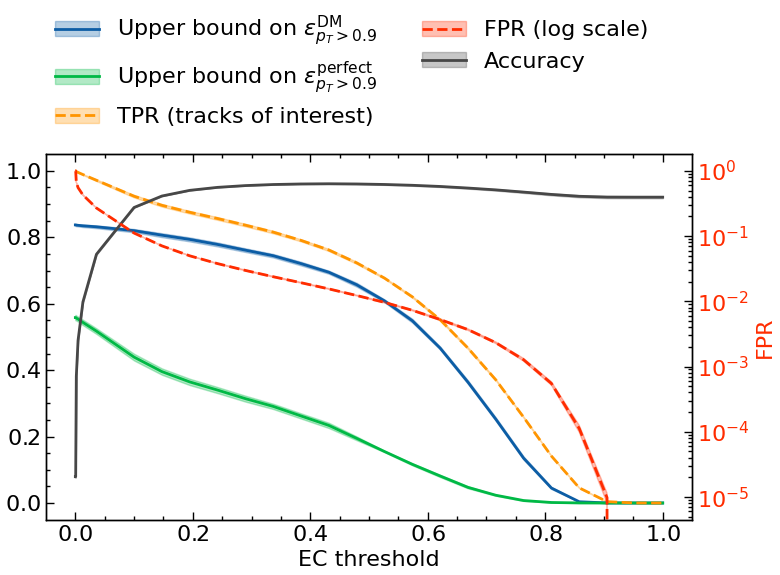

In [55]:
tpip = ThresholdPossibilityInfoPlot(dfmdm)
tpip.plot()
tpip.plot_errorline("acc", label="Accuracy", ls="-", color="C5")
tpip.add_legend(loc=(0, 1.05), ncols=2)
tpip.ax.get_figure().tight_layout()
# tpip.ax.get_figure().savefig("tpip.pdf")

In [45]:
dfmdm.iloc[0].to_dict()

{'threshold': 0.0,
 'n_particles_pt0.9_err': 80.96567173808909,
 'n_particles_pt0.9': 1247.2,
 'n_cleaned_clusters_pt0.9_err': 68.75419987171692,
 'n_cleaned_clusters_pt0.9': 1076.2,
 'perfect_pt0.9_err': 0.007891726515666712,
 'perfect_pt0.9': 0.5582644150513046,
 'double_majority_pt0.9_err': 0.0034745757525572285,
 'double_majority_pt0.9': 0.8373291718035174,
 'lhc_pt0.9_err': 0.0,
 'lhc_pt0.9': 1.0,
 'fake_perfect_pt0.9_err': 0.00752687358824501,
 'fake_perfect_pt0.9': 0.3533372384360559,
 'fake_double_majority_pt0.9_err': 0.001494224761284752,
 'fake_double_majority_pt0.9': 0.02999018159006044,
 'fake_lhc_pt0.9_err': 0.0,
 'fake_lhc_pt0.9': 0.0,
 'acc_thld_err': 0.01785341368646047,
 'acc_thld': 0.5777117850766519,
 'TPR_thld_err': 0.0,
 'TPR_thld': 1.0,
 'TNR_thld_err': 0.0,
 'TNR_thld': 0.0,
 'FPR_thld_err': 0.0,
 'FPR_thld': 1.0,
 'FNR_thld_err': 0.0,
 'FNR_thld': 0.0,
 'balanced_acc_thld_err': 0.0,
 'balanced_acc_thld': 0.5,
 'F1_thld_err': 0.014581576351869827,
 'F1_thld': 0.7